In [1]:
!git clone https://github.com/millermuttu/TSAI-EVA5.git
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

Cloning into 'TSAI-EVA5'...
remote: Enumerating objects: 353, done.
remote: Counting objects: 100% (353/353), done.
remote: Compressing objects: 100% (274/274), done.
remote: Total 353 (delta 154), reused 227 (delta 68), pack-reused 0
Receiving objects: 100% (353/353), 4.11 MiB | 7.59 MiB/s, done.
Resolving deltas: 100% (154/154), done.
     |████████████████████████████████| 122kB 9.1MB/s 
     |████████████████████████████████| 952kB 16.5MB/s 
albumentations==0.4.6 is successfully installed


In [2]:
cd /content/TSAI-EVA5/week11/

/content/TSAI-EVA5/week11


In [3]:
import torch
import dataset
import models
import utils
import visual
import gradcam
import numpy as np
from torchvision import transforms
from train_test import train, test, train_ocp
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
cuda, device = utils.misc.initialize_device(utils.config.SEED)

GPU Available? True


In [5]:
# setting the configs
utils.config.BATCH_SIZE = 512
utils.config.EPOCHS = 24
utils.config.NUM_WORKERS = 16

In [6]:
trainset = dataset.pytorch_datasets(True, True, dataset_name='cifar10')
testset = dataset.pytorch_datasets(False, True, dataset_name='cifar10')

Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to /content/TSAI-EVA5/week11/dataset/cifar10/cifar-10-python.tar.gz


Extracting /content/TSAI-EVA5/week11/dataset/cifar10/cifar-10-python.tar.gz to /content/TSAI-EVA5/week11/dataset/cifar10
Files already downloaded and verified


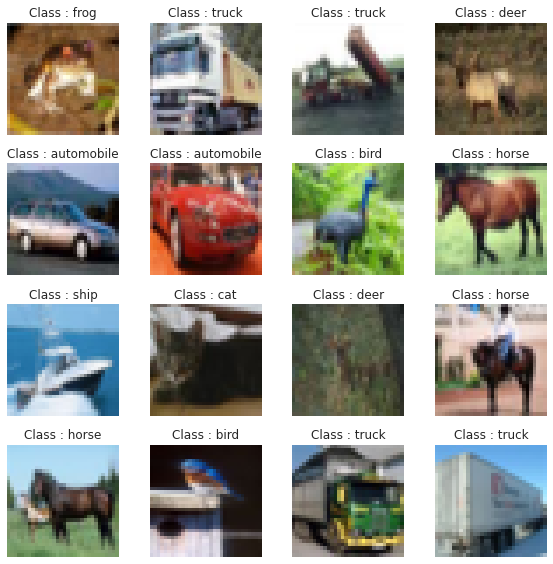

In [7]:
visual.visualization.show_imgs(trainset, 16, (8, 8))

In [7]:
mean, std = dataset.img_reg.get_stats(trainset)[0], dataset.img_reg.get_stats(trainset)[1]
print(mean, std)

(0.4914, 0.4822, 0.4465) (0.247, 0.2435, 0.2616)


In [9]:
transformations_list = [A.Normalize(mean, std)]
augmentations_list = [A.PadIfNeeded(40,40),
                      A.RandomCrop(32,32),
                      A.HorizontalFlip(p=0.2), 
                      # A.Rotate(limit=10),
                      A.Cutout(1, 8, 8, fill_value=mean, p=0.2),
                     ]

In [10]:
trainset = dataset.pytorch_datasets(True, True, transformations_list, augmentations_list, dataset_name='cifar10')
testset = dataset.pytorch_datasets(False, True, transformations_list, dataset_name='cifar10')
train_dl = dataset.data_loader(trainset, utils.config.BATCH_SIZE, utils.config.NUM_WORKERS, cuda, shuffle=True)
test_dl = dataset.data_loader(testset, utils.config.BATCH_SIZE, utils.config.NUM_WORKERS, cuda, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
#Define model
model = models.A11().to(device)

In [12]:
utils.misc.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

In [13]:
model = models.A11().to(device)
loss_fn = utils.misc.cross_entropy_loss_fn()
optimizer = utils.misc.sgd_optimizer(model,lr=0.00001)

In [14]:
lr_finder = utils.lr_finder.LRFinder(model, optimizer, loss_fn, device=device)
lr_finder.range_test(train_dl, end_lr=100, num_iter=100)

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 1.35E-04


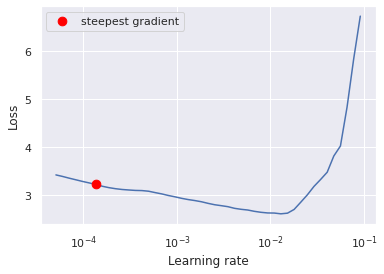

(<matplotlib.axes._subplots.AxesSubplot at 0x7ff6283d3da0>,
 0.00013530477745798074)

In [15]:
lr_finder.plot()

In [16]:
# reset the lr graph
lr_finder.reset()

In [17]:
model = models.A11().to(device)
loss_fn = utils.misc.cross_entropy_loss_fn()
optimizer = utils.misc.sgd_optimizer(model)
scheduler = utils.misc.one_cycle_lr(optimizer=optimizer,max_lr=0.1,epochs=utils.config.EPOCHS,steps_per_epoch=len(train_dl),pct_start=5/utils.config.EPOCHS,div_factor=10,final_div_factor=5)

if utils.config.DEBUG == True:
    utils.config.EPOCHS = 15

test_loss = []
test_accuracy = []
train_losses = []
train_accuracy = []
misclassified_imgs = []
for epoch in range(utils.config.EPOCHS):
    print(f"Running Epoch {epoch+1}/{utils.config.EPOCHS}\n")
    train_ocp(model, train_dl, optimizer,scheduler, loss_fn, device, train_losses, train_accuracy)
    tl = test(model, test_dl, loss_fn, device, 25, test_loss, test_accuracy, misclassified_imgs)

  0%|          | 0/98 [00:00<?, ?it/s]

Running Epoch 1/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0046, Accuracy: 2777/10000 (27.77%)

Running Epoch 2/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0049, Accuracy: 2785/10000 (27.85%)

Running Epoch 3/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0034, Accuracy: 4276/10000 (42.76%)

Running Epoch 4/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0028, Accuracy: 5206/10000 (52.06%)

Running Epoch 5/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0022, Accuracy: 6271/10000 (62.71%)

Running Epoch 6/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0020, Accuracy: 6716/10000 (67.16%)

Running Epoch 7/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0017, Accuracy: 7175/10000 (71.75%)

Running Epoch 8/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0015, Accuracy: 7574/10000 (75.74%)

Running Epoch 9/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0013, Accuracy: 7905/10000 (79.05%)

Running Epoch 10/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0011, Accuracy: 8173/10000 (81.73%)

Running Epoch 11/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0011, Accuracy: 8082/10000 (80.82%)

Running Epoch 12/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0010, Accuracy: 8345/10000 (83.45%)

Running Epoch 13/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0011, Accuracy: 8260/10000 (82.60%)

Running Epoch 14/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0009, Accuracy: 8525/10000 (85.25%)

Running Epoch 15/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0009, Accuracy: 8515/10000 (85.15%)

Running Epoch 16/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0008, Accuracy: 8679/10000 (86.79%)

Running Epoch 17/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0008, Accuracy: 8738/10000 (87.38%)

Running Epoch 18/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0007, Accuracy: 8803/10000 (88.03%)

Running Epoch 19/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0007, Accuracy: 8864/10000 (88.64%)

Running Epoch 20/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0007, Accuracy: 8874/10000 (88.74%)

Running Epoch 21/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0007, Accuracy: 8910/10000 (89.10%)

Running Epoch 22/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0007, Accuracy: 8926/10000 (89.26%)

Running Epoch 23/24



  0%|          | 0/98 [00:00<?, ?it/s]


Validation set: Average loss: 0.0007, Accuracy: 8971/10000 (89.71%)

Running Epoch 24/24



Loss=0.16 Batch_ID=97 Accuracy=95.05: 100%|██████████| 98/98 [00:17<00:00,  5.75it/s]



Validation set: Average loss: 0.0006, Accuracy: 9001/10000 (90.01%)



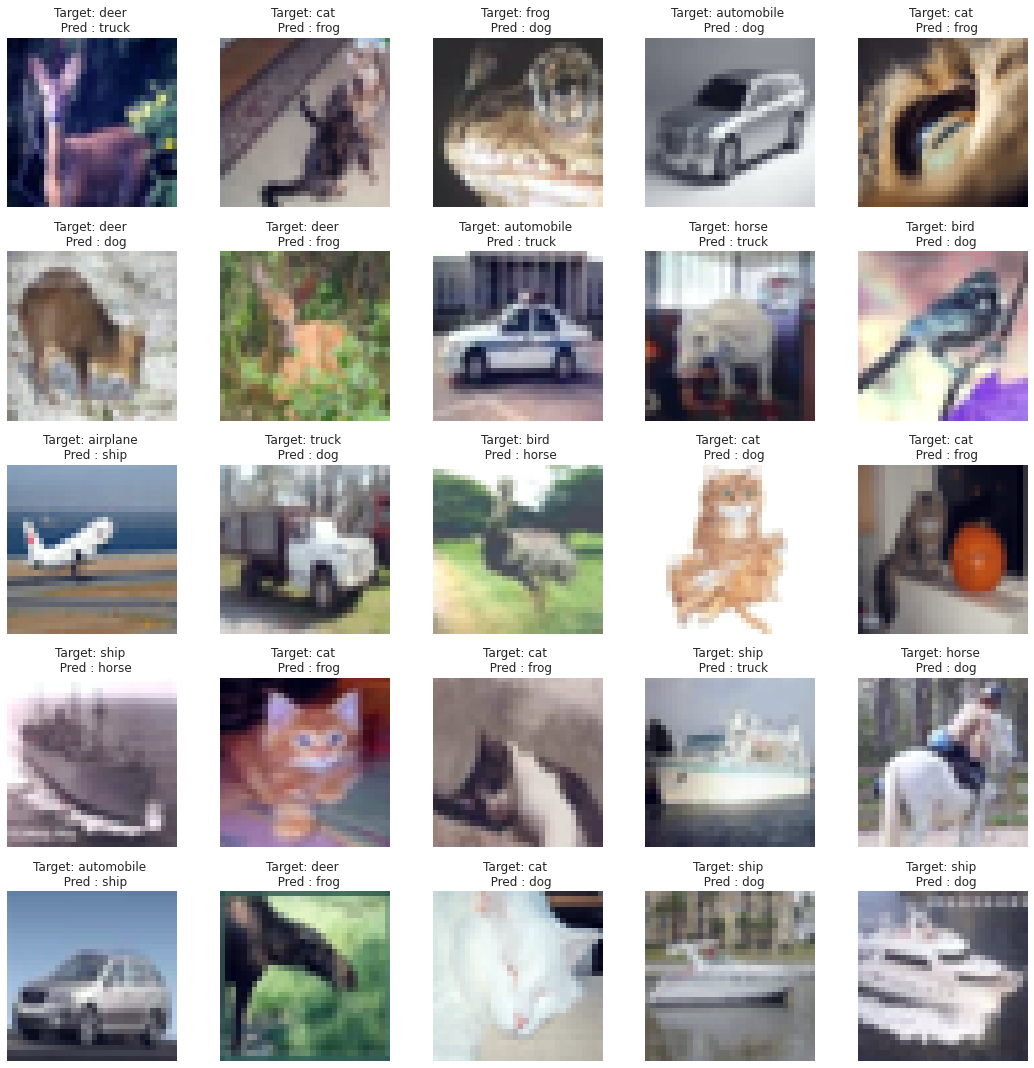

In [18]:
class_idx = trainset.class_to_idx
visual.plot_incorrect_images(misclassified_imgs,class_idx)

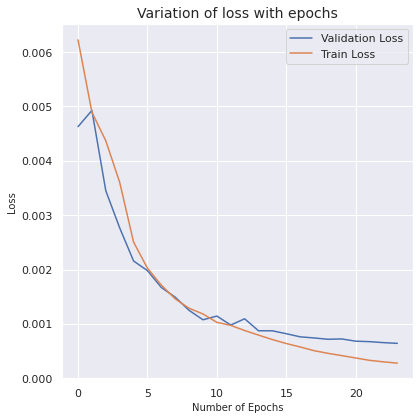

In [19]:
visual.plot_metrics([{'metric':test_loss, 'label':'Validation Loss'},
                    {'metric':train_losses, 'label':'Train Loss'}], "Loss")

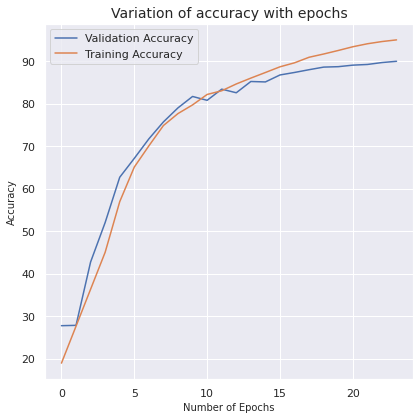

In [20]:
visual.plot_metrics([{'metric':test_accuracy, 'label':'Validation Accuracy'},
                    {'metric':train_accuracy, 'label':'Training Accuracy'}], "Accuracy")

#ploting the cyclic graph

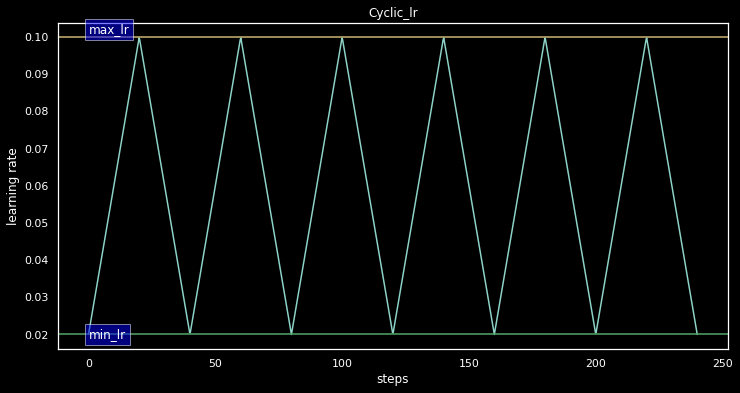

In [21]:
max_lr = 0.1
min_lr = 0.1/5
visual.plot_clr(6,20,max_lr,min_lr)